In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hrnet/tensorflow2/v2-w48/1/saved_model.pb
/kaggle/input/hrnet/tensorflow2/v2-w48/1/variables/variables.index
/kaggle/input/hrnet/tensorflow2/v2-w48/1/variables/variables.data-00000-of-00001
/kaggle/input/hrnet/tensorflow2/hrnet-camvid-hrnetv2-w48/1/saved_model.pb
/kaggle/input/hrnet/tensorflow2/hrnet-camvid-hrnetv2-w48/1/variables/variables.index
/kaggle/input/hrnet/tensorflow2/hrnet-camvid-hrnetv2-w48/1/variables/variables.data-00000-of-00001
/kaggle/input/football-player-segmentation/annotations/instances_default.json
/kaggle/input/football-player-segmentation/images/208.jpg
/kaggle/input/football-player-segmentation/images/473.jpg
/kaggle/input/football-player-segmentation/images/333.jpg
/kaggle/input/football-player-segmentation/images/45.jpg
/kaggle/input/football-player-segmentation/images/369.jpg
/kaggle/input/football-player-segmentation/images/56.jpg
/kaggle/input/football-player-segmentation/images/89.jpg
/kaggle/input/football-player-segmentation/images/20.jpg


In [3]:
import os
import numpy as np
import cv2
import zipfile
import requests
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
import warnings
import logging
import absl


2024-02-27 09:03:29.682038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 09:03:29.682204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 09:03:29.879900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Download immagini di esempio provenienti dal dataset CamVid, dataset attraverso il qualche il modello che si sta utilizzando è stato allenato.**

In [89]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)
    
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [90]:
download_file( 
    'https://www.dropbox.com/s/5jhbvmqgzbzl9fd/camvid_images.zip?dl=1',
    'camvid_images.zip'
)
    
unzip(zip_file='camvid_images.zip')

Extracted all


In [91]:
image_paths = sorted(glob.glob('camvid_images' + '/*.png'))

for idx in range(len(image_paths)):
    print(image_paths[idx])


camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


In [92]:
def load_image(path):

    image = cv2.imread(path)
    
    # BGR to RBG
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Add batch dimension
    image = np.expand_dims(image, axis=0)/255.0
    
    return image

Nel contesto di un modello di segmentazione semantica, l'aggiunta di una dimensione batch si riferisce a come vengono elaborate le immagini da parte del modello durante l'addestramento o l'inferenza. Generalmente, i modelli di deep learning vengono addestrati su batch di dati anziché su singole istanze. L'aggiunta di una dimensione batch significa trattare un insieme di immagini come un batch, consentendo al modello di elaborarle simultaneamente.

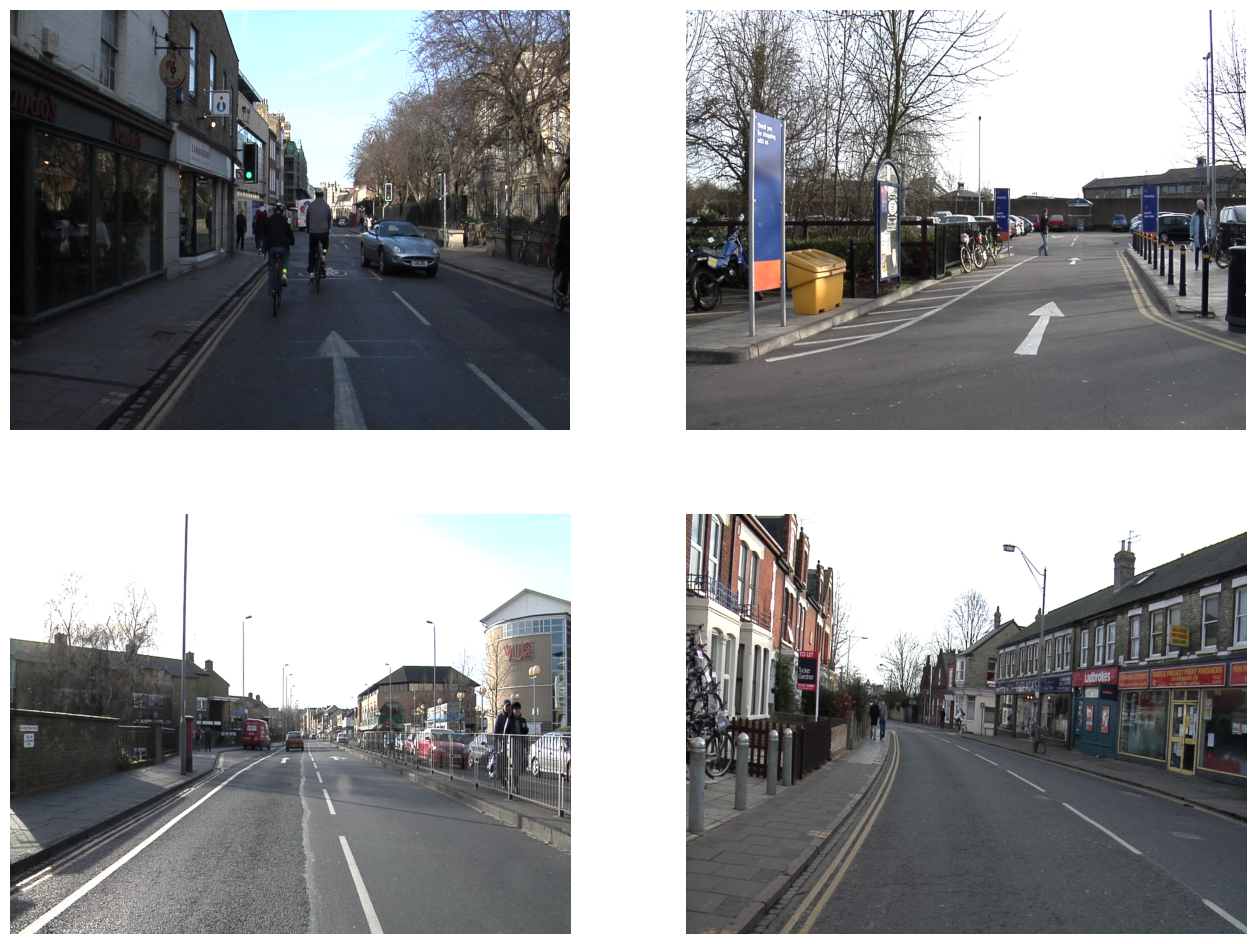

In [100]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis('off')

Dalla documentazione del Dataset CamVid ecco una lista delle classi presenti associate al valore RGB corrispondente nella segmentation mask finale.

In [101]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']  
    }

**Inferenza sul modello hrnet**

In [134]:
model = hub.load('https://kaggle.com/models/google/hrnet/frameworks/TensorFlow2/variations/v2-w48/versions/1')

Attaching model 'google/hrnet/tensorflow2/v2-w48/1' to your Kaggle notebook...


In [113]:
pred_mask = model.predict(images[0])

print('Shape of predicted mask: ', pred_mask.shape)

Shape of predicted mask:  (1, 720, 960, 33)


La maschera di segmentazione prevista restituita dal modello contiene un canale separato per ciascuna classe. Ciascun canale contiene la probabilità che un dato pixel dell'immagine in input sia associato alla classe di quel canale. Questi dati, pertanto, richiedono una certa post-elaborazione per ottenere risultati significativi. È necessario eseguire diversi passaggi per arrivare ad una rappresentazione visiva finale. Rimuovere la dimensione batch e la classe background. Assegna un'etichetta di classe a ogni pixel dell'immagine in base al punteggio di probabilità più alto su tutti i canali. Pertanto, dobbiamo mappare questi ID di classe su valori RGB in modo da poter visualizzare i risultati come una mappa di segmentazione codificata a colori.

In [114]:
pred_mask = pred_mask.numpy()

#remove background class
pred_mask = pred_mask[:,:,:,1:]

#rimuovo dimensione batch tramite squeeze che riduce la dimensionalità
pred_mask = np.squeeze(pred_mask)

print('Shape of predicted mask : ', pred_mask.shape)

Shape of predicted mask :  (720, 960, 32)


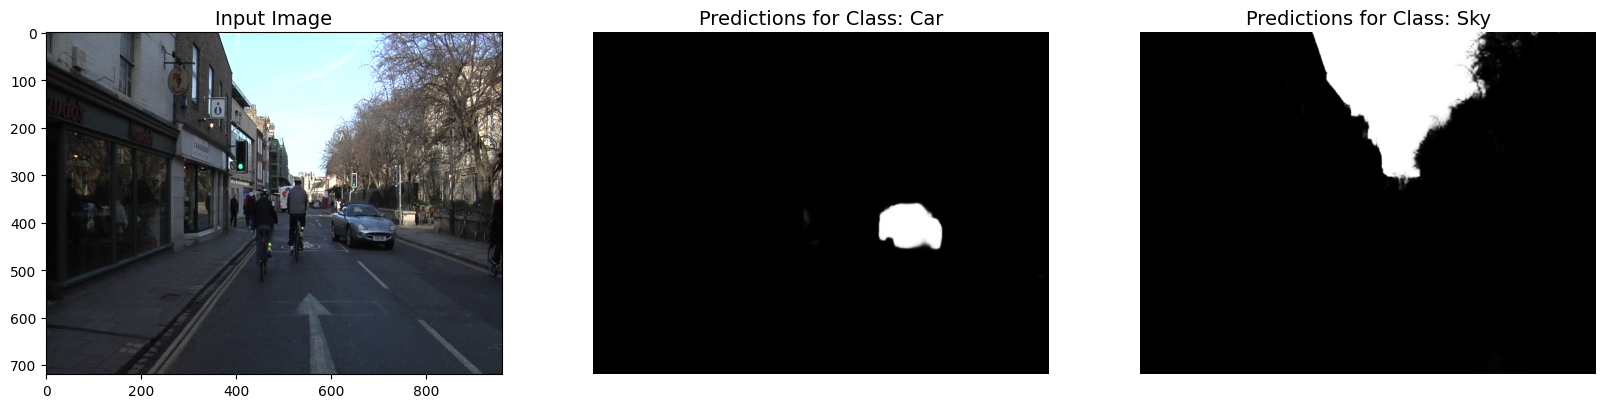

In [104]:
# Ogni canale in pred_mask contiene le probabilità per ogni pixel di appartenere alla classe corrente
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1,3,2)
plt.title('Predictions for Class: Car', fontsize=14)
plt.imshow(pred_mask[:,:,5], cmap='gray');  
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Predictions for Class: Sky', fontsize=14)
plt.imshow(pred_mask[:,:,21], cmap='gray');  
plt.axis('off');

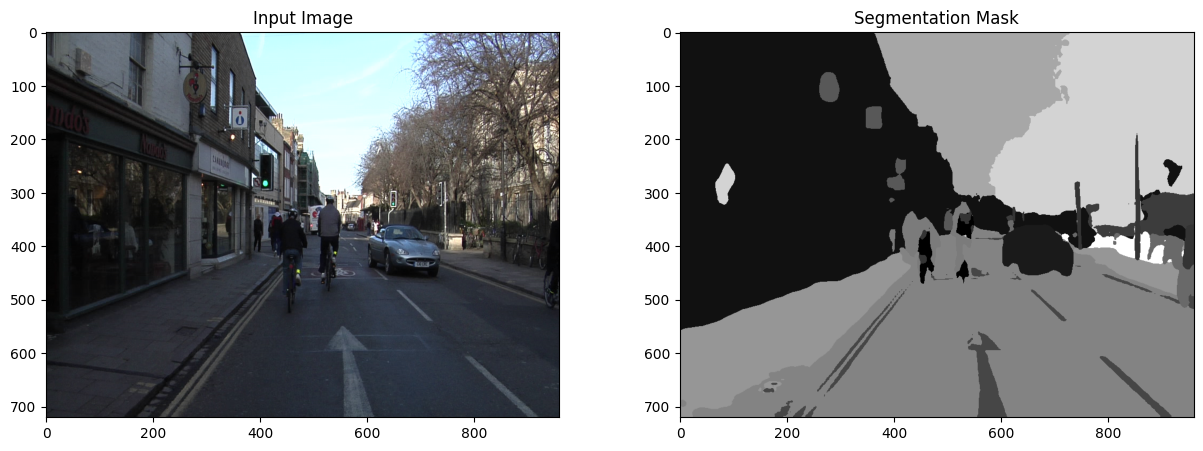

In [106]:

# assegnare quindi ogni pixel alla classe con probabilità più alta
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15,5)); 

plt.subplot(1,2,1)
plt.title('Input Image', fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1,2,2)
plt.title('Segmentation Mask', fontsize=12)
plt.imshow(pred_mask_class, cmap='gray') 

In [108]:
def class_to_rgb(mask_class, class_index):
    
    # Create RGB channels.
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)
    
    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]
        
    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)
        
    return seg_map_rgb

In [110]:
def plot_color_legend(class_index):
    
    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]    
   
    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace = 0.5, hspace=0.01)
    
    # Display color legend.
    for i, axis in enumerate(ax.flat):

        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize = 8)
        axis.axis('off')

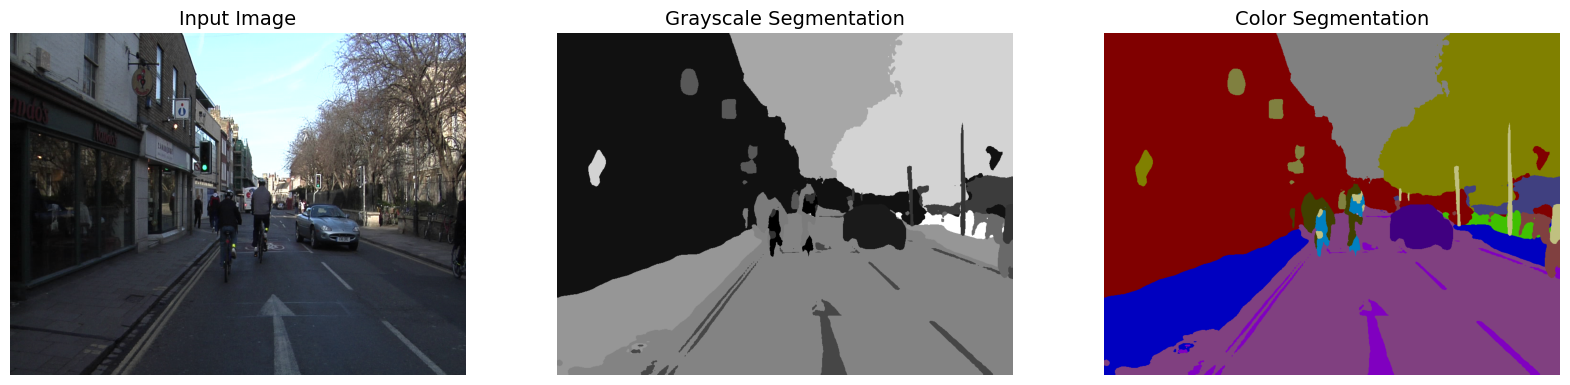

In [109]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)  

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(images[0]))
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Grayscale Segmentation', fontsize=14)
plt.imshow(pred_mask_class, cmap='gray') 
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Color Segmentation', fontsize=14)
plt.imshow(pred_mask_rgb, cmap='gray') 
plt.axis('off');

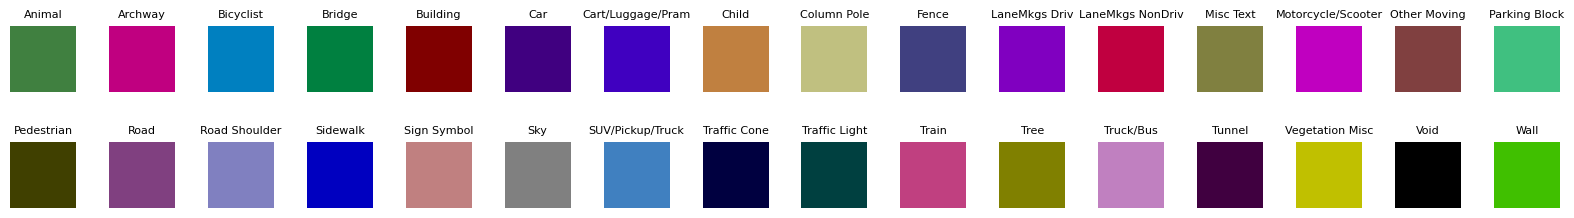

In [111]:
plot_color_legend(class_index)